## Data and fetching

In [8]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io
from psyfun.config import *
from psyfun import plots
import matplotlib as pl
from matplotlib import pyplot as plt

one = ONE()

In [9]:
# Fetching all session, insertion, and spike data
# DAVIDE: for some reason, fetching keeps getting interrupted by the absence of certain files/directories.

#%run -i fetchdata.py -a

In [10]:
# storing session/insertion metadata
df_sessions = pd.read_parquet(paths['sessions'])
df_insertions = pd.read_parquet(paths['insertions'])

c:\Users\marti\Documents\mainen\psychedelics\psyfun\plots.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_qc = df[qc_columns].replace(qcval2num)


'\nVideo data for most sessions, only three missing. Good?\n'

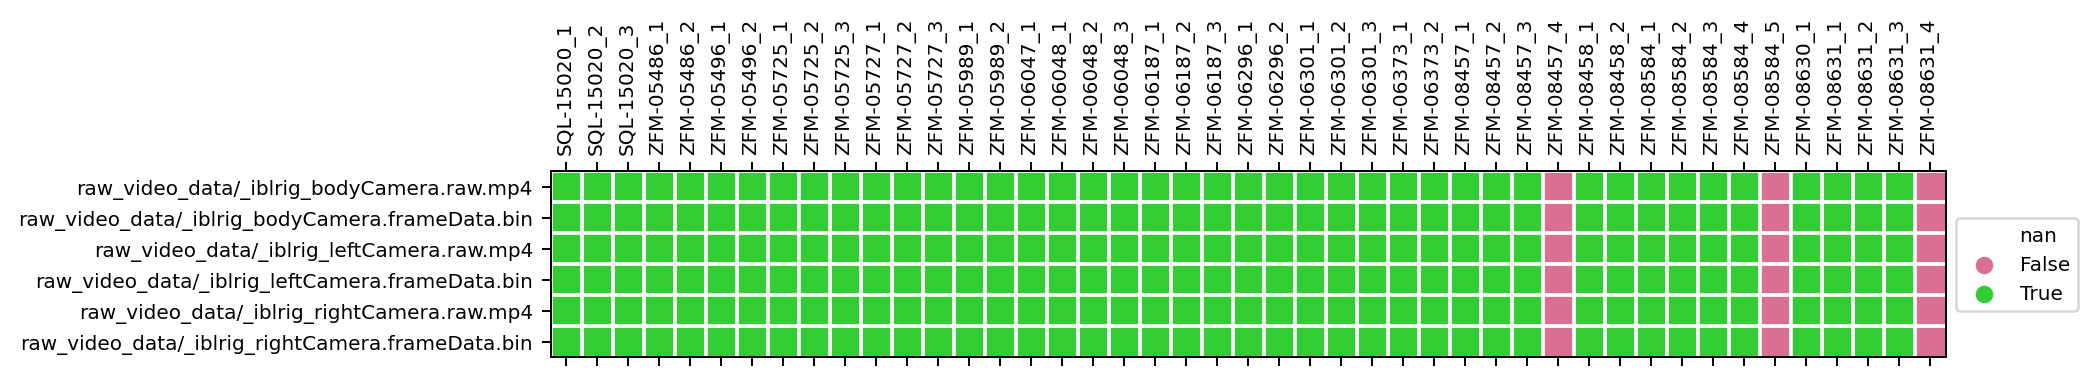

In [11]:
# Check which video datasets exist for each session
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_datasets['video'],  qcval2num=qcval2num, xticklabels=xticklabels)
fig = ax.get_figure()
fig.set_figwidth(10)

"""
Video data for most sessions, only three missing. Good?
"""

'\nLeft cameras have constant ~60FPS and a null number of dropped frames.\nThe one thing about higher FPS is that FaceMap will have to work with higher binning parameters to optimize the process,\ncausing a high loss of information.\n\nNonetheless, important to compare left and right video, especially because right videos also have a lower dropped-frame rate.\n'

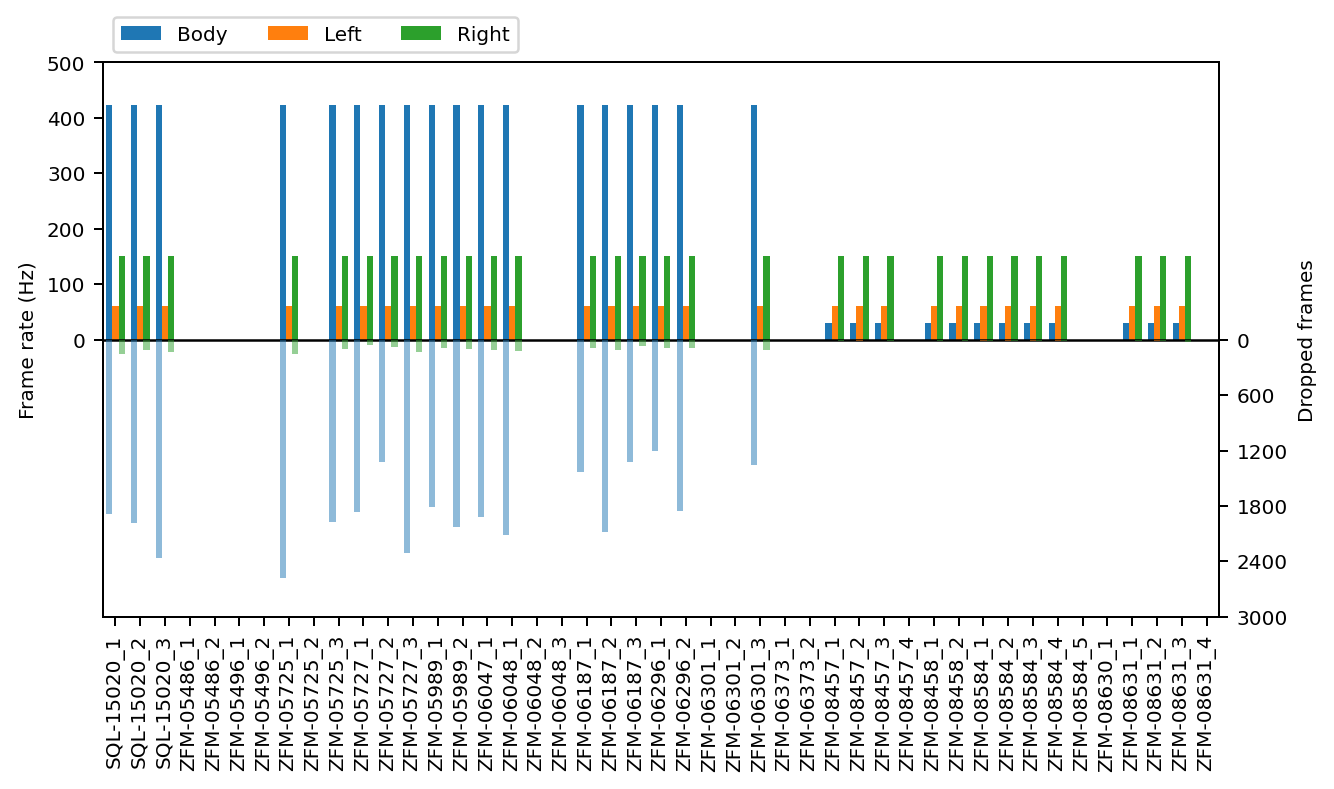

In [12]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)

"""
Left cameras have constant ~60FPS and a null number of dropped frames.
The one thing about higher FPS is that FaceMap will have to work with higher binning parameters to optimize the process,
causing a high loss of information.

Nonetheless, important to compare left and right video, especially because right videos also have a lower dropped-frame rate.
"""

## Setting up (active video processing)

In [13]:
# getting all eid that contain a left camera (should be all but three)

df_eid = df_sessions.loc[df_sessions['raw_video_data/_iblrig_leftCamera.raw.mp4'] == True, 'eid'] #left

In [18]:
import os

eid = df_eid[0]

# Download raw video, return path
video_path = one.load_dataset(eid, f'*leftCamera.raw*', collection='raw_video_data')



100%|██████████| 15/15.0 [00:06<00:00,  2.28it/s]


In [19]:
print(video_path)

C:\Users\marti\Downloads\ONE\alyx.internationalbrainlab.org\mainenlab\Subjects\SQL-15020\2023-03-21\001\raw_video_data\_iblrig_leftCamera.raw.mp4


## quality control and my little suboptimal pca

In [21]:
from suboptimal_PCA import run_pca

# Use io.video to stream video data instead of dodwnloading full videos
import ibllib.io.video as vidio
label = 'left' # 'left', 'right' or 'body'

# Find url of video data to stream
# url = vidio.url_from_eid(eid, one=one)[label]

# Load the first 10 video frames
frames = vidio.get_video_frames_preload(video_path, range(10))
print(frames.shape)

# Get video metadata
meta = vidio.get_video_meta(video_path, one=one)

(10, 1024, 1280, 3)[2K


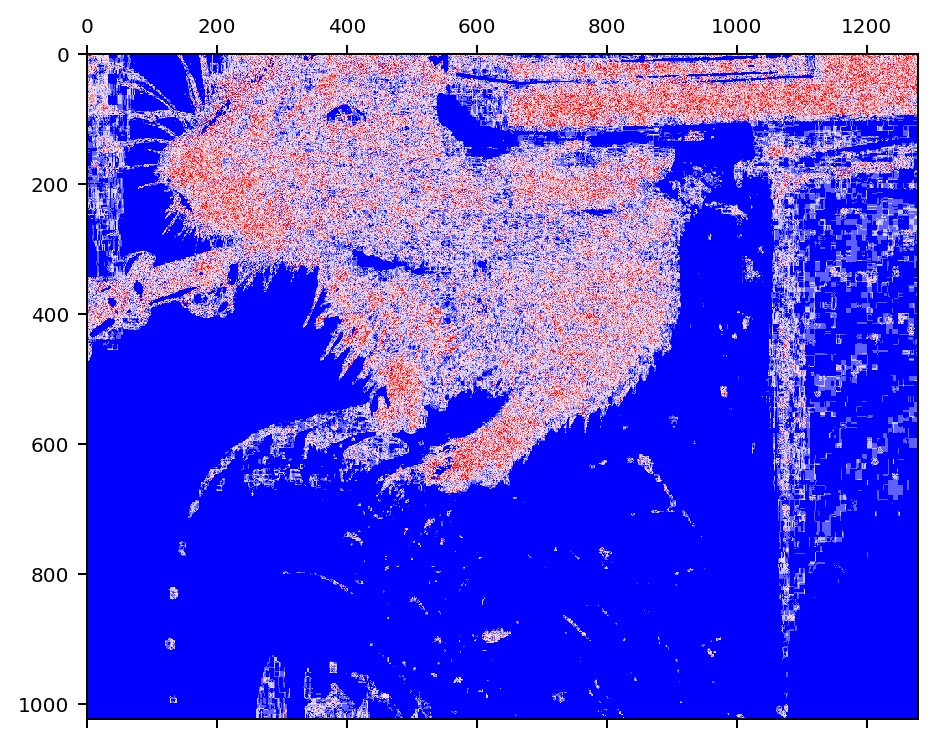

In [ ]:
# checking pixel differences
frame = frames[0,...]
assert np.allclose(frame[...,0], frame[...,1])
assert np.allclose(frame[...,0], frame[...,2])
assert np.allclose(frame[...,1], frame[...,2])

# plotting example frame
"""
I am concerned about luminosity at the wheel ROI - most of PC1 differences came from that section. Must check diff matrix
"""
#fig, ax = plt.subplots()
#ax.matshow(frame[...,0], cmap ='bwr', vmin = 0, vmax = 250)

# plotting average motion energy for 10 example frames
avg_diff = np.diff(frames[...,0], axis = 0)
avg_diff = np.mean(avg_diff, axis = 0)

fig1, ax1 = plt.subplots()
ax1.matshow(avg_diff, cmap = 'bwr', vmin = 0, vmax = 150)

# Video Processing (API)

In [ ]:
import facemap
import facemap.process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import scipy.optimize
import seaborn as sns
from scipy.stats import entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

download_path = 'C:\Users\marti\Documents\mainen\psychedelics\video'

facemap.process.run(video_path, sbin = 4, motSVD = True, savepath=download_path)

NameError: name 'download_path' is not defined

In [38]:
facemap.process.run?

Signature:
facemap.process.run(
    filenames,
    sbin=1,
    motSVD=True,
    movSVD=False,
    GUIobject=None,
    parent=None,
    proc=None,
    savepath=None,
)
Docstring:
Process video files using SVD computation of motion and/or raw movie data. 
Parameters
----------
filenames: 2D-list
    List of video files to process. Each element of the list is a list of
    filenames for video(s) recorded simultaneously. For example, if two videos were recorded simultaneously, the list would be: [['video1.avi', 'video2.avi']], and if the videos were recorded sequentially, the list would be: [['video1.avi'], ['video2.avi']].
sbin: int
    Spatial binning factor. If sbin > 1, the movie will be spatially binned by a factor of sbin.
motSVD: bool
    If True, compute SVD of motion in the video i.e. the difference between consecutive frames.
movSVD: bool
    If True, compute SVD of raw movie data.
GUIobject: GUI object
    GUI object to update progress bar. If None, no progress bar will be updat